**MLB Games Won Predicter**

In [0]:
#-------------------------------------
#--  import
#-------------------------------------
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import io
import requests

%matplotlib inline

sns.set(rc={'figure.figsize': (12, 10), "lines.markeredgewidth": 0.5 })



Supporting Functions

In [0]:
def predictAL(model_results, ERA_Plus,SV,OPS_Plus,Num_AllStars, R):
    const, ERA_Plus_coeff, SV_coeff, OPS_Plus_coeff, Num_AllStars_coeff, R_coeff = model_results.params
    return const + ERA_Plus_coeff * ERA_Plus + SV_coeff * SV + OPS_Plus_coeff * OPS_Plus + Num_AllStars_coeff * Num_AllStars + R_coeff * R 

def predictStat(Stat,games):
    return Stat * 162 / games

def probability(model_results, value):
    const, coeff = model_results.params
    exponent = -(const + coeff * value)
    denominator = 1 + np.exp(exponent)
    return 1 / denominator

def remove_outliers(dataframe, column):
    q1 = dataframe[column].quantile(0.25)
    q3 = dataframe[column].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return dataframe[(dataframe[column] >= lower) &
                     (dataframe[column] <= upper)].copy()
  
def replace_Tm_Abr(value):
    if value in Tm_Abr_Map:
        return Tm_Abr_Map[value]
    else:
        print("BAD VALUE replace_Tm_Abr *********************************************************",value)
        return 'UNKNOWN'
    
def replace_Tm_League_Map(value):
    if value in Tm_League_Map:
        return Tm_League_Map[value]
    else:
        print("BAD VALUE replace_Tm_League_Map *********************************************************",value)
        return 'UNKNOWN'
    
def replace_Tm_Abr_City(value):
    if value in Tm_Abr_City_Map:
        return Tm_Abr_City_Map[value]
    else:
        print("BAD VALUE replace_Tm_Abr_City *********************************************************",value)
        return 'UNKNOWN'
  
#def replace_Metro_With_City(value):
#    if value in metro_area_city_map:
#        return metro_area_city_map[value]
#    else:
#        print("BAD VALUE replace_Metro_With_City *********************************************************",value)
#        return 'UNKNOWN'

def replace_Team_With_Division(value):
    if value in Tm_Division_Map:
        return Tm_Division_Map[value]
    else:
        print("BAD VALUE replace_Tm_Division_Map *********************************************************",value)
        return 'UNKNOWN'
    
Tm_Division_Map = {
	'Yankees':'East',
   'Red Sox':'East',
   'Blue Jays':'East',
   'Rays':'East',
   'Orioles':'East',
   'Indians':'Central',
   'Tigers':'Central',
   'Twins':'Central',
   'White Sox':'Central',
   'Royals':'Central',
   'Astros':'West',
   'Mariners':'West',
   'Angels':'West',
   'Athletics':'West',
   'Rangers':'West',
   'Braves':'East',
   'Phillies':'East',
   'Nationals':'East',
   'Mets':'East',
   'Marlins':'East',
   'Cubs':'Central',
   'Brewers':'Central',
   'Cardinals':'Central',
   'Pirates':'Central',
   'Reds':'Central',
   'Diamondbacks':'West',
   'Dodgers':'West',
   'Giants':'West',
   'Rockies':'West',
   'Padres':'West',
}    
    

Tm_League_Map = {
	'ARI':'NL',
	'ATL':'NL',
	'BAL':'AL',
	'BOS':'AL',
   'CAL':'AL',
	'CHC':'NL',
	'CHW':'AL',
	'CIN':'NL',
	'CLE':'AL',
	'COL':'NL',
	'DET':'AL',
   'FLA':'AL',
	'HOU':'AL',
	'KCR':'AL',
	'LAA':'AL',
   'ANA':'AL',
	'LAD':'NL',
	'MIA':'NL',
	'MIL':'NL',
	'MIN':'AL',
	'NYM':'NL',
	'NYY':'AL',
	'OAK':'AL',
	'PHI':'NL',
	'PIT':'NL',
	'SDP':'NL',
	'SEA':'AL',
	'SFG':'NL',
	'STL':'NL',
	'TBR':'AL',
   'TBD':'AL',
	'TEX':'AL',
	'TOR':'AL',
	'WSN':'NL',
   'MON':'NL',
   '':'BLAH',
}

Tm_Abr_Map = {
	'ARI':'Diamondbacks',
	'ATL':'Braves',
	'BAL':'Orioles',
	'BOS':'Red Sox',
	'CHC':'Cubs',
	'CHW':'White Sox',
	'CIN':'Reds',
	'CLE':'Indians',
	'COL':'Rockies',
	'DET':'Tigers',
	'HOU':'Astros',
	'KCR':'Royals',
	'CAL':'Angels',
   'LAA':'Angels',
   'ANA':'Angels',
	'LAD':'Dodgers',
   'FLA':'Marlins',
	'MIA':'Marlins',
	'MIL':'Brewers',
	'MIN':'Twins',
	'NYM':'Mets',
	'NYY':'Yankees',
	'OAK':'Athletics',
	'PHI':'Phillies',
	'PIT':'Pirates',
	'SDP':'Padres',
	'SEA':'Mariners',
	'SFG':'Giants',
	'STL':'Cardinals',
   'TBD':'Rays',
	'TBR':'Rays',
	'TEX':'Rangers',
	'TOR':'Blue Jays',
	'WSN':'Nationals',
   'MON':'Nationals'
}

Tm_Abr_City_Map = {
    'ARI':'Arizona',
    'ATL':'Atlanta',
    'BAL':'Baltimore',
    'BOS':'Boston',
    'CHC':'Chicago',
    'CHW':'Chicago',
    'CIN':'Cincinnati',
    'CLE':'Cleveland',
    'COL':'Colorado',
    'DET':'Detroit',
    'HOU':'Houston',
    'KCR':'Kansas City',
    'CAL': 'Los Angeles',
    'LAA': 'Los Angeles',
    'ANA':'Los Angeles',
    'LAD':'Los Angeles',
    'FLA':'Miami',
    'MIA':'Miami',
    'MIL':'Milwaukee',
    'MIN':'Minneapolis',
    'NYM':'New York',
    'NYY':'New York',
    'OAK':'Oakland',
    'PHI':'Philadelphia',
    'PIT':'Pittsburgh',
    'SDP':'San Diego',
    'SEA':'Seattle',
    'SFG':'San Francisco',
    'STL':'St Louis',
    'TBR':'Tampa',
    'TEX':'Dallas',
    'TOR':'Toronto',
    'WAS':'Washington',
    'WSN':'Washington',
    'MON':'Washington'
}


Read Input Files

In [70]:
#--------------------------------------------------------
#--  Input File 1:  Games Won By Team 
#--------------------------------------------------------
#mlb = pd.read_csv('GamesWonByTeam.csv')
url="https://raw.githubusercontent.com/dniedermier-cscc/Scrum-Lords-Capstone-2018/master/Data/Major_League_Baseball/GamesWonByTeam.csv"
s=requests.get(url).content
mlb=pd.read_csv(io.StringIO(s.decode('utf-8')))

mlb['City'] = mlb.Tm.apply(replace_Tm_Abr_City)
mlb['Team'] = mlb.Tm.apply(replace_Tm_Abr)
mlb['GamesWon'] = mlb.GamesWon.astype(int)
mlb['League'] = mlb.Tm.apply(replace_Tm_League_Map)

print(mlb.head(5))

    Tm  Year  GamesWon       City          Team League
0  ARI  2018        31    Arizona  Diamondbacks     NL
1  ATL  2018        35    Atlanta        Braves     NL
2  BAL  2018        17  Baltimore       Orioles     AL
3  BOS  2018        41     Boston       Red Sox     AL
4  CHC  2018        33    Chicago          Cubs     NL


In [71]:
#--------------------------------------------------------
#--  Input File 2:  Batting Stats by Team
#--------------------------------------------------------
url="https://raw.githubusercontent.com/dniedermier-cscc/Scrum-Lords-Capstone-2018/master/Data/Major_League_Baseball/BattingStats.csv"

a=requests.get(url).content
batting_all=pd.read_csv(io.StringIO(a.decode('utf-8')))

batting_all['Team'] = batting_all.apply(lambda _: '', axis=1)
batting_all.Team = batting_all.Tm.apply(replace_Tm_Abr)

print(batting_all.head(5))

    Tm  #Bat  BatAge   R/G    G    PA    AB    R     H   2B      ...       \
0  ARI    45    28.3  5.01  162  6224  5525  812  1405  314      ...        
1  ATL    49    28.7  4.52  162  6216  5584  732  1467  289      ...        
2  BAL    50    28.6  4.59  162  6140  5650  743  1469  269      ...        
3  BOS    49    27.3  4.85  162  6338  5669  785  1461  302      ...        
4  CHC    47    27.1  5.07  162  6283  5496  822  1402  274      ...        

   OPS_Plus    TB  GDP  HBP  SH  SF  IBB   LOB  Year          Team  
0        94  2457  106   54  39  27   44  1118  2017  Diamondbacks  
1        95  2303  137   66  59  32   57  1127  2017        Braves  
2        98  2458  138   50  10  37   12  1041  2017       Orioles  
3        91  2305  141   53   9  36   48  1134  2017       Red Sox  
4        98  2403  134   82  48  32   54  1147  2017          Cubs  

[5 rows x 31 columns]


In [72]:
#--------------------------------------------------------
#--  Input File 3:  Pitching Stats by Team
#--------------------------------------------------------
url="https://raw.githubusercontent.com/dniedermier-cscc/Scrum-Lords-Capstone-2018/master/Data/Major_League_Baseball/pitchingstats.csv"
b=requests.get(url).content
pitching_all=pd.read_csv(io.StringIO(b.decode('utf-8')))

pitching_all['Team'] = pitching_all.apply(lambda _: '', axis=1)
pitching_all.Team = pitching_all.Tm.apply(replace_Tm_Abr)

print(pitching_all.head(5))

   Year   Tm  #P  PAge  RA/G   W   L   W-L%   ERA    G      ...        WHIP  \
0  2017  ARI  23  28.7  4.07  93  69  0.574  3.66  162      ...       1.266   
1  2017  ATL  26  29.4  5.07  72  90  0.444  4.72  162      ...       1.420   
2  2017  BAL  26  28.2  5.19  75  87  0.463  4.97  162      ...       1.446   
3  2017  BOS  27  28.4  4.12  93  69  0.574  3.70  162      ...       1.247   
4  2017  CHC  28  30.8  4.29  92  70  0.568  3.95  162      ...       1.277   

    H9  HR9  BB9  SO9  SO/W     LOB  Unnamed: 35  Unnamed: 36          Team  
0  8.2  1.1  3.2  9.3  2.87  1090.0          NaN          NaN  Diamondbacks  
1  9.1  1.2  3.6  7.9  2.15  1161.0          NaN          NaN        Braves  
2  9.4  1.5  3.6  7.7  2.13  1129.0          NaN          NaN       Orioles  
3  8.4  1.2  2.8  9.6  3.40  1102.0          NaN          NaN       Red Sox  
4  8.0  1.2  3.4  8.9  2.60  1071.0          NaN          NaN          Cubs  

[5 rows x 38 columns]


In [0]:
#--------------------------------------------------------
#--  Input File 4:  List of Playoff Teams
#--------------------------------------------------------
#url="https://raw.githubusercontent.com/dniedermier-cscc/Scrum-Lords-Capstone-2018/master/Data/Major_League_Baseball/PlayoffTeams.csv"
#c=requests.get(url).content
#playoffs_all=pd.read_csv(io.StringIO(c.decode('utf-8')))

#playoffs_all['Team'] = playoffs_all.apply(lambda _: '', axis=1)
#playoffs_all.Team = playoffs_all.Tm.apply(replace_Tm_Abr)
#playoffs_all['Playoffs'] = True

#print(playoffs_all.head(5))

In [74]:
#--------------------------------------------------------
#--  Input File 5:  Attendance + Misc Team Data
#--------------------------------------------------------
url="https://raw.githubusercontent.com/dniedermier-cscc/Scrum-Lords-Capstone-2018/master/Data/Major_League_Baseball/Attend.csv"
d=requests.get(url).content
attend_all=pd.read_csv(io.StringIO(d.decode('utf-8')))

myAttendColumns = ['Year',
             'City',
             'Team',
             'Attendance', 
             'Attend/G',
             'BatAge',
             'PAge',
             '#A-S',
             'Est. Payroll',
             'Time']

attend_all['City'] = attend_all.apply(lambda _: '', axis=1)
attend_all.City = attend_all.Tm.apply(replace_Tm_Abr_City)
attend_all['City'] = attend_all.Tm.apply(replace_Tm_Abr_City)
attend_all['Team'] = attend_all.apply(lambda _: '', axis=1)
attend_all.Team = attend_all.Tm.apply(replace_Tm_Abr)
attend = attend_all[myAttendColumns].copy()

attend.rename(
    {'Year': 'Year',
     'City': 'City',
     'Team': 'Team',
     'Attendance': 'Attendance', 
     'Attend/G': 'Attendance_Per_Game',
     'BatAge': 'Average_Batter_Age',
     'PAge': 'Average_Pitcher_Age',
     '#A-S': 'Num_AllStars',
     'Est. Payroll': 'Payroll',
     'Time': 'Time_Per_Game'
     },
    axis=1 ,
    inplace=True
)

#--clean the data
attend['Attendance'] = attend['Attendance'].str.replace(',', '')
attend['Attendance'] = attend.Attendance.astype(int)
attend['Payroll'] = attend['Payroll'].str.replace(',','')
attend['Payroll'] = attend['Payroll'].str.replace('$','')
attend['Payroll'] = attend.Payroll.astype(int)

print(attend.head(5))

   Year       City          Team  Attendance Attendance_Per_Game  \
0  2017    Arizona  Diamondbacks     2134375              26,350   
1  2017    Atlanta        Braves     2505252              30,929   
2  2017  Baltimore       Orioles     2028424              25,042   
3  2017     Boston       Red Sox     2917678              36,021   
4  2017    Chicago          Cubs     3199562              39,501   

   Average_Batter_Age  Average_Pitcher_Age  Num_AllStars    Payroll  \
0                28.3                 28.7             4  106580200   
1                28.6                 29.4             1  119705250   
2                28.6                 28.2             1  161621633   
3                27.3                 28.4             3  200550750   
4                27.1                 30.8             1  177210667   

  Time_Per_Game  
0          3:09  
1          3:04  
2          3:09  
3          3:20  
4          3:09  


In [75]:
#===============================================================================
#     MERGE DATA
#===============================================================================

#--- Only AL data
AL = mlb[mlb.League == 'AL']

#--merge in batting data
AL = AL.merge(batting_all, on=["Year", "Team","Tm"])
#--merge in pitching data
AL = AL.merge(pitching_all, on=["Year", "Team","Tm"])
#--merge in playoff data
#AL = AL.merge(playoffs_all, on=["Year", "Team","Tm"], how='left')
#--merge in mlb attendance data
AL = AL.merge(attend, on=["Year", "Team","City"])

print(AL.head(5))

    Tm  Year  GamesWon       City       Team League  #Bat  BatAge   R/G  G_x  \
0  BAL  2017        75  Baltimore    Orioles     AL    50    28.6  4.59  162   
1  BOS  2017        93     Boston    Red Sox     AL    49    27.3  4.85  162   
2  CHW  2017        67    Chicago  White Sox     AL    51    26.7  4.36  162   
3  CLE  2017       102  Cleveland    Indians     AL    41    28.0  5.05  162   
4  DET  2017        64    Detroit     Tigers     AL    49    29.6  4.54  162   

       ...         LOB_y  Unnamed: 35  Unnamed: 36  Attendance  \
0      ...        1129.0          NaN          NaN     2028424   
1      ...        1102.0          NaN          NaN     2917678   
2      ...        1115.0          NaN          NaN     1629470   
3      ...         980.0          NaN          NaN     2048138   
4      ...        1143.0          NaN          NaN     2321599   

   Attendance_Per_Game  Average_Batter_Age  Average_Pitcher_Age  Num_AllStars  \
0               25,042                28.

ONly Use 2016 and greater data - we will later predict 2017 games won

In [0]:
AL_all = AL
AL = AL[AL.Year < 2017]

DETERMINE STRONGEST CORRELATION

In [77]:
AL_Corr = AL.corr()
AL_Corr.sort_values(['GamesWon'], inplace = True,ascending=False)
print(AL_Corr.GamesWon[0:15])

W               1.000000
GamesWon        1.000000
W-L%            0.999887
ERA_Plus        0.730120
SV              0.643671
OPS_Plus        0.638645
Num_AllStars    0.601699
RBI             0.591801
R               0.585184
R/G             0.584378
OPS             0.566893
OBP             0.540663
SLG             0.538029
TB              0.509125
Attendance      0.462326
Name: GamesWon, dtype: float64


In [78]:
AL_no_outliers = AL.copy()

AL_no_outliers = remove_outliers(AL_no_outliers, 'ERA_Plus')
AL_no_outliers = remove_outliers(AL_no_outliers, 'OPS_Plus')
AL_no_outliers = remove_outliers(AL_no_outliers, 'SV')
AL_no_outliers = remove_outliers(AL_no_outliers, 'Num_AllStars')
AL_no_outliers = remove_outliers(AL_no_outliers, 'RBI')
AL_no_outliers = remove_outliers(AL_no_outliers, 'R')
AL_no_outliers = remove_outliers(AL_no_outliers, 'R/G')
AL_no_outliers = remove_outliers(AL_no_outliers, 'OPS')
AL_no_outliers = remove_outliers(AL_no_outliers, 'OBP')
AL_no_outliers = remove_outliers(AL_no_outliers, 'SLG')
AL_no_outliers = remove_outliers(AL_no_outliers, 'TB')

#AL_no_outliers.corr().to_csv('myCorr-NoOutliers.csv')
print('\n------------------------------ Games Won - No Outliers ------------------------------')
AL_Corr_no_outliers = AL_no_outliers.corr()
AL_Corr_no_outliers.sort_values(['GamesWon'], inplace = True,ascending=False)
print(AL_Corr_no_outliers.GamesWon[0:15])


------------------------------ Games Won - No Outliers ------------------------------
W               1.000000
GamesWon        1.000000
W-L%            0.999898
ERA_Plus        0.731825
SV              0.625454
OPS_Plus        0.615883
Num_AllStars    0.570990
RBI             0.557202
R               0.549062
R/G             0.548046
OPS             0.535876
SLG             0.510308
OBP             0.503125
TB              0.478306
tSho            0.461855
Name: GamesWon, dtype: float64


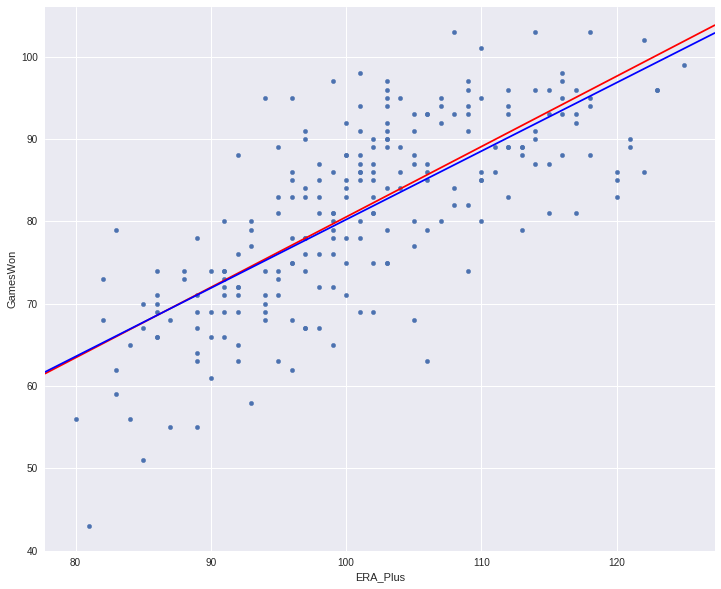

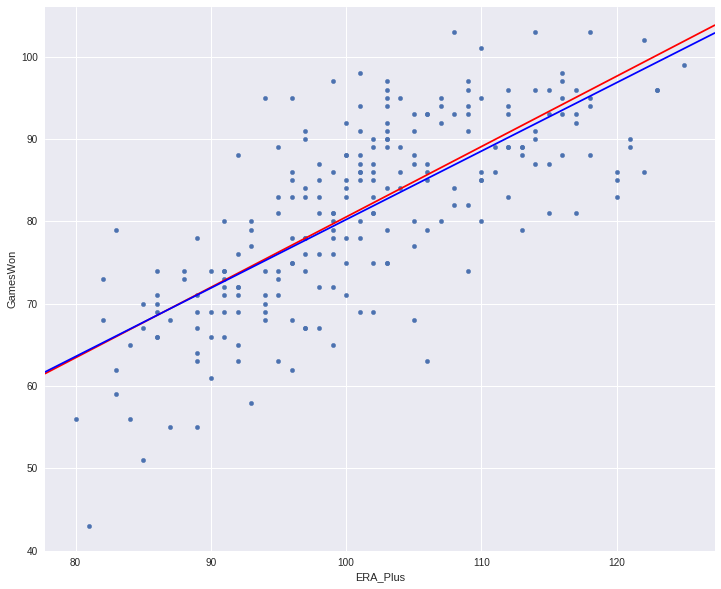

In [79]:
#===============================================================================
#     DISPLAY ERA_PLUS RELATIONSHIP	
#===============================================================================
X = sm.add_constant(AL.ERA_Plus)
Y = AL.GamesWon
model = sm.OLS(Y, X)
res = model.fit()

X = sm.add_constant(AL_no_outliers.ERA_Plus)
Y = AL_no_outliers.GamesWon
model = sm.OLS(Y, X)
res2 = model.fit()


from statsmodels.graphics.regressionplots import abline_plot
axes = AL_no_outliers.plot.scatter(x="ERA_Plus", y="GamesWon")
abline_plot(model_results=res, ax=axes, color='r')
abline_plot(model_results=res2, ax=axes, color='b')


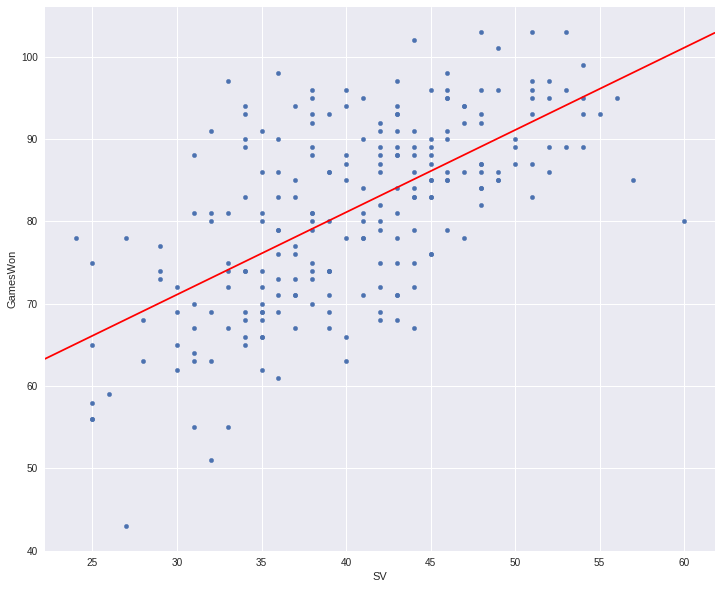

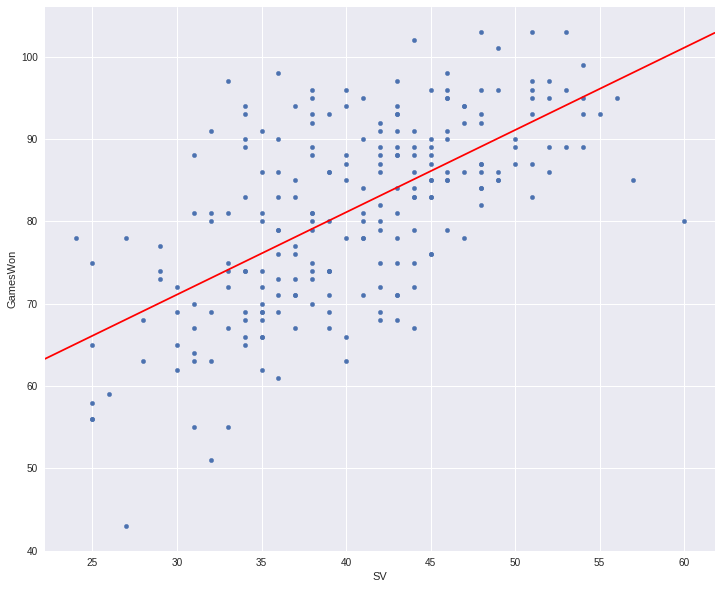

In [80]:
#===============================================================================
#     DISPLAY SV RELATIONSHIP	
#===============================================================================
X = sm.add_constant(AL.SV)
Y = AL.GamesWon
model = sm.OLS(Y, X)
res3 = model.fit()

X = sm.add_constant(AL_no_outliers.SV)
Y = AL_no_outliers.GamesWon
model = sm.OLS(Y, X)
res4 = model.fit()


from statsmodels.graphics.regressionplots import abline_plot
axes = AL_no_outliers.plot.scatter(x="SV", y="GamesWon")
abline_plot(model_results=res3, ax=axes, color='r')


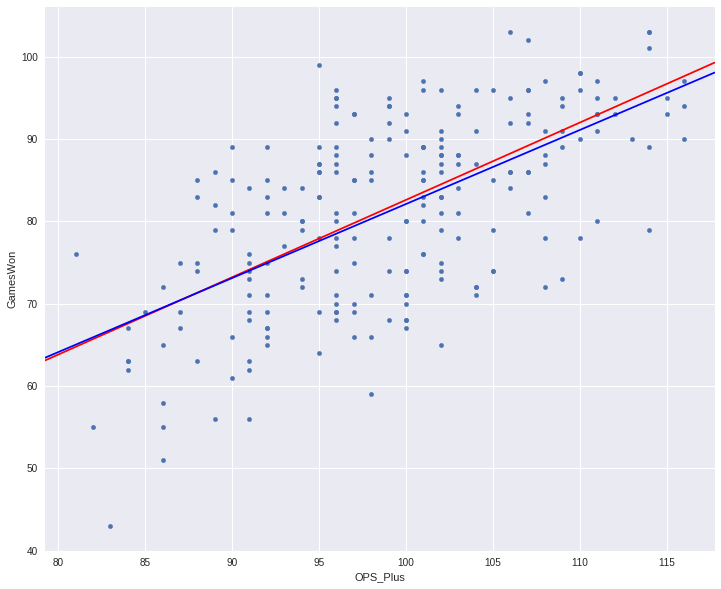

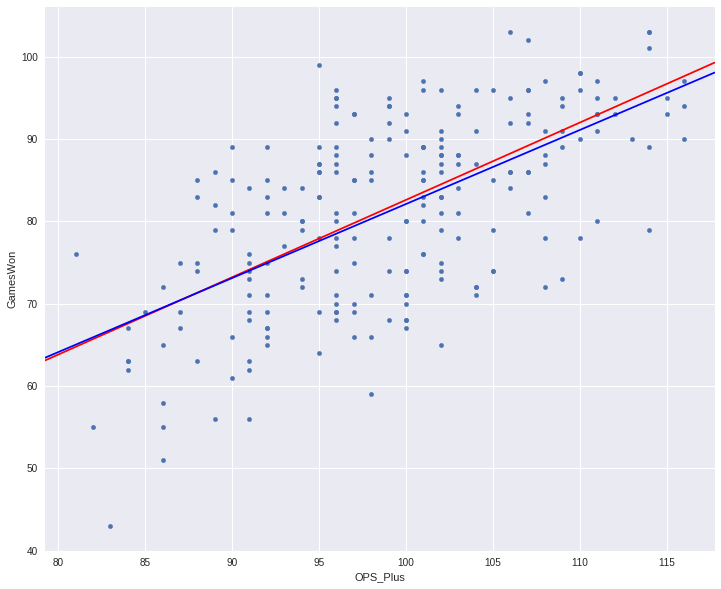

In [81]:
#===============================================================================
#     DISPLAY OPS_PLUS RELATIONSHIP	
#===============================================================================
X = sm.add_constant(AL.OPS_Plus)
Y = AL.GamesWon
model = sm.OLS(Y, X)
res5 = model.fit()

X = sm.add_constant(AL_no_outliers.OPS_Plus)
Y = AL_no_outliers.GamesWon
model = sm.OLS(Y, X)
res6 = model.fit()


from statsmodels.graphics.regressionplots import abline_plot
axes = AL_no_outliers.plot.scatter(x="OPS_Plus", y="GamesWon")
abline_plot(model_results=res5, ax=axes, color='r')
abline_plot(model_results=res6, ax=axes, color='b')


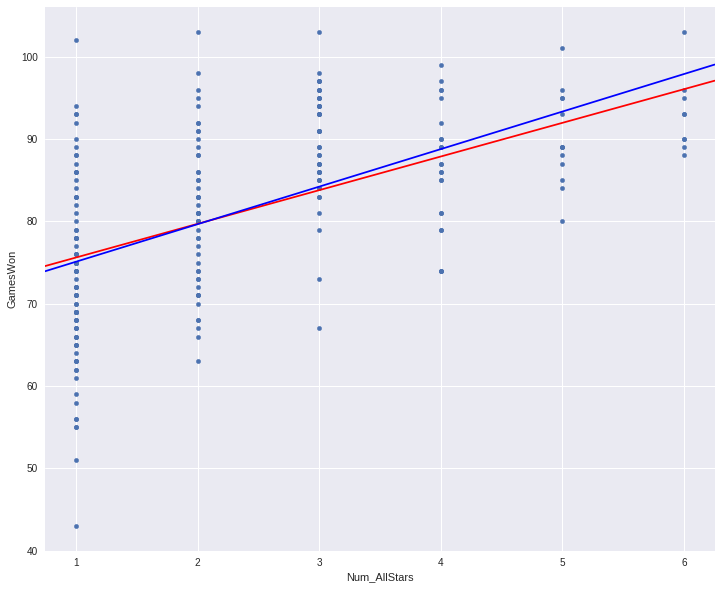

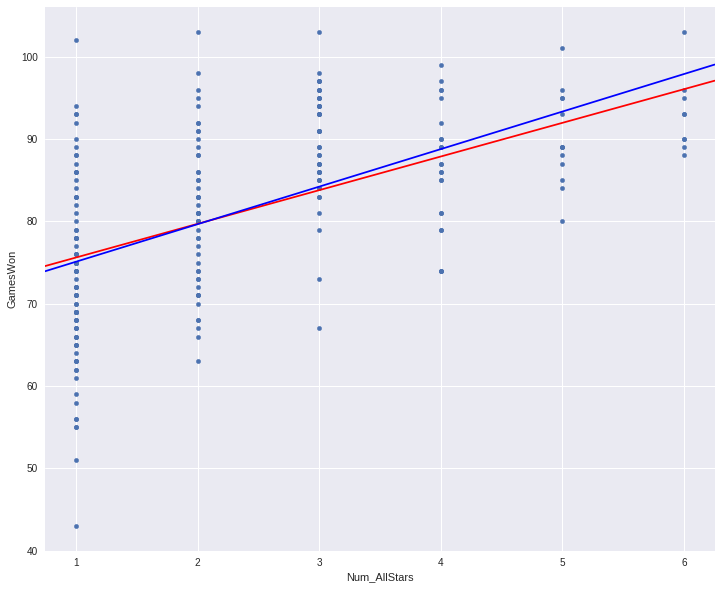

In [82]:
#===============================================================================
#     DISPLAY NUM_ALLSTARS RELATIONSHIP	
#===============================================================================
X = sm.add_constant(AL.Num_AllStars)
Y = AL.GamesWon
model = sm.OLS(Y, X)
res7 = model.fit()

X = sm.add_constant(AL_no_outliers.Num_AllStars)
Y = AL_no_outliers.GamesWon
model = sm.OLS(Y, X)
res8 = model.fit()


from statsmodels.graphics.regressionplots import abline_plot
axes = AL_no_outliers.plot.scatter(x="Num_AllStars", y="GamesWon")
abline_plot(model_results=res7, ax=axes, color='r')
abline_plot(model_results=res8, ax=axes, color='b')


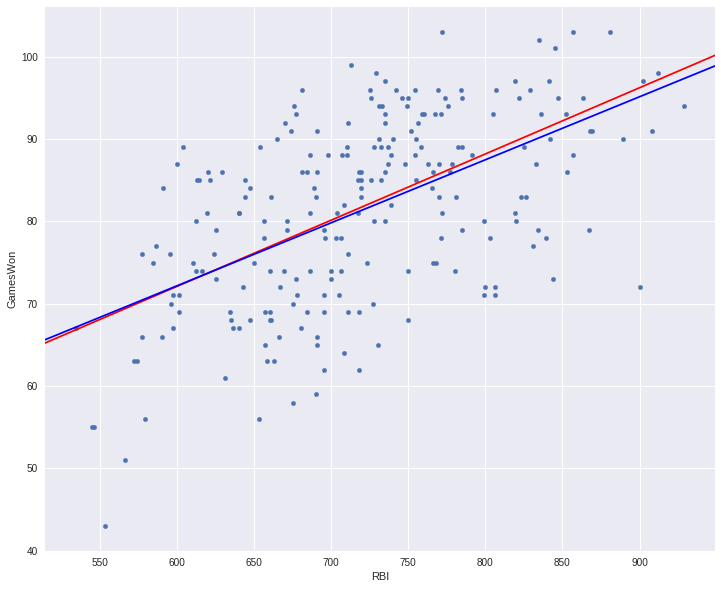

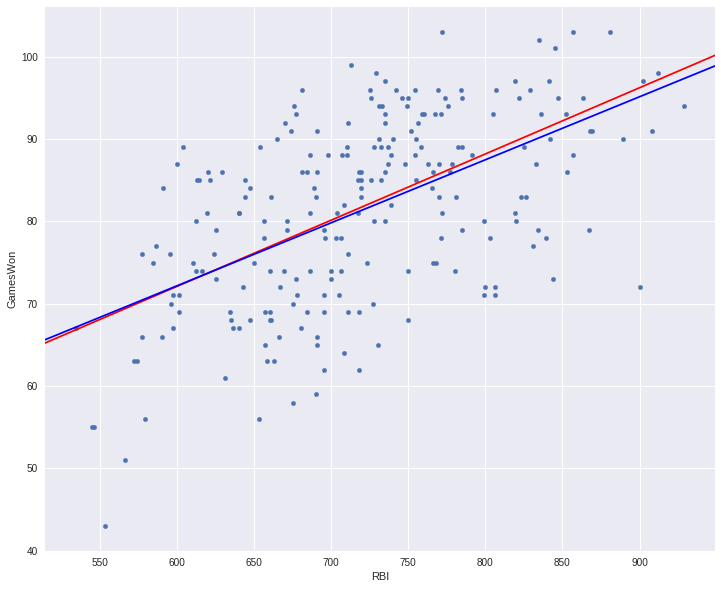

In [83]:
#===============================================================================
#     DISPLAY RBI RELATIONSHIP	
#===============================================================================
X = sm.add_constant(AL.RBI)
Y = AL.GamesWon
model = sm.OLS(Y, X)
res9 = model.fit()

X = sm.add_constant(AL_no_outliers.RBI)
Y = AL_no_outliers.GamesWon
model = sm.OLS(Y, X)
res10 = model.fit()

from statsmodels.graphics.regressionplots import abline_plot
axes = AL_no_outliers.plot.scatter(x="RBI", y="GamesWon")
abline_plot(model_results=res9, ax=axes, color='r')
abline_plot(model_results=res10, ax=axes, color='b')


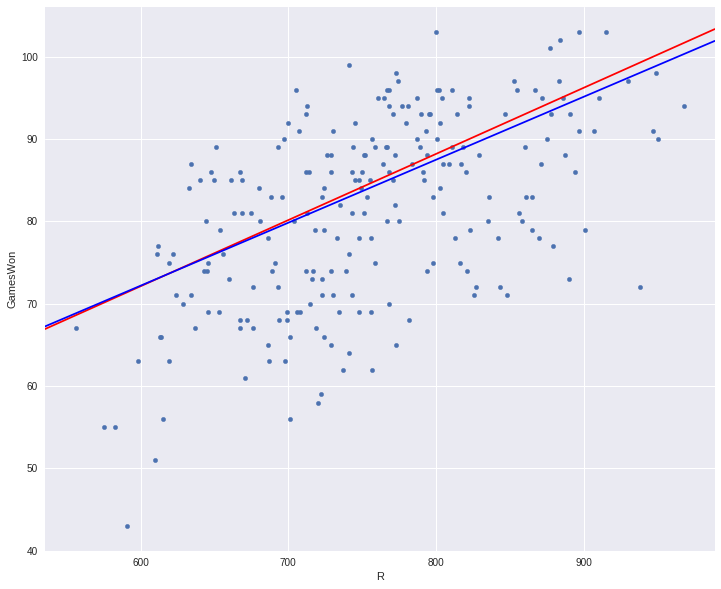

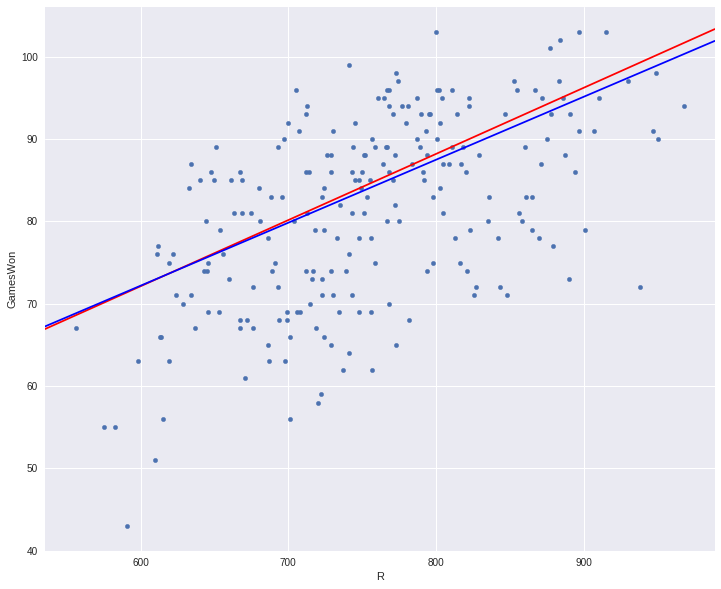

In [84]:
#===============================================================================
#     DISPLAY R RELATIONSHIP	
#===============================================================================
X = sm.add_constant(AL.R)
Y = AL.GamesWon
model = sm.OLS(Y, X)
res11 = model.fit()

X = sm.add_constant(AL_no_outliers.R)
Y = AL_no_outliers.GamesWon
model = sm.OLS(Y, X)
res12 = model.fit()

from statsmodels.graphics.regressionplots import abline_plot
axes = AL_no_outliers.plot.scatter(x="R", y="GamesWon")
abline_plot(model_results=res9, ax=axes, color='r')
abline_plot(model_results=res10, ax=axes, color='b')


In [85]:
#===============================================================================
#     PREDICT RESULTS	
#===============================================================================
X = sm.add_constant(AL_no_outliers[['ERA_Plus','SV','OPS_Plus','Num_AllStars','RBI','R']])
Y = AL_no_outliers.GamesWon
model = sm.OLS(Y, X)
res = model.fit()
display(res.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               GamesWon   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     281.2
Date:                Sun, 08 Jul 2018   Prob (F-statistic):          1.74e-100
Time:                        18:54:27   Log-Likelihood:                -630.79
No. Observations:                 228   AIC:                             1276.
Df Residuals:                     221   BIC:                             1300.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -65.9366      4.867    -13.548      0.000     -75.528     -56.345
ERA_Plus         0.5636      0.032     17.700      0.000       0.501       0.626
SV               0.4492      0.043     10.375      0.000       0.364       0.535
OPS_Plus         0.5688      0.053     10.701      0.000       0.464       0.673
Num_AllStars     0.4709      0.225      2.090      0.038       0.027       0.915
RBI             -0.0577      0.039     -1.487      0.139      -0.134       0.019
R                0.0742      0.037      1.987      0.048       0.001       0.148
==============================================================================
Omnibus:                        1.111   Durbin-Watson:                   2.243
Prob(Omnibus):                  0.574   Jarque-Bera (JB):                1.099
Skew:                           0.046   Prob(JB):                        0.577
Kurtosis:                       2.672   Cond. No.                     1.99e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
#--p hat on RBI is too high - remove
X = sm.add_constant(AL_no_outliers[['ERA_Plus','SV','OPS_Plus','Num_AllStars','R']])
Y = AL_no_outliers.GamesWon
model = sm.OLS(Y, X)
res = model.fit()
display(res.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               GamesWon   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     335.1
Date:                Sun, 08 Jul 2018   Prob (F-statistic):          2.71e-101
Time:                        18:54:27   Log-Likelihood:                -631.92
No. Observations:                 228   AIC:                             1276.
Df Residuals:                     222   BIC:                             1296.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -63.6816      4.637    -13.734      0.000     -72.820     -54.544
ERA_Plus         0.5618      0.032     17.608      0.000       0.499       0.625
SV               0.4433      0.043     10.254      0.000       0.358       0.529
OPS_Plus         0.5513      0.052     10.607      0.000       0.449       0.654
Num_AllStars     0.4807      0.226      2.129      0.034       0.036       0.926
R                0.0191      0.005      4.193      0.000       0.010       0.028
==============================================================================
Omnibus:                        0.828   Durbin-Watson:                   2.233
Prob(Omnibus):                  0.661   Jarque-Bera (JB):                0.900
Skew:                           0.050   Prob(JB):                        0.638
Kurtosis:                       2.709   Cond. No.                     1.38e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Predict 2017 Games Won

In [87]:
myYear = AL_all[AL_all.Year == 2017]

teams_to_predictAL = myYear[['Year', 'Team', 'ERA_Plus','SV','Num_AllStars','OPS_Plus','Attendance','GamesWon','R','RBI']].copy()
teams_to_predictAL['myGamesWon'] = teams_to_predictAL.apply(lambda _: '', axis=1)
for index, row in teams_to_predictAL.iterrows():
    calcGames = predictAL(res, row['ERA_Plus'], row['SV'], row['OPS_Plus'], row['Num_AllStars'],row['R'])
    teams_to_predictAL.set_value(index,'myGamesWon', calcGames)

teams_to_predictAL['GamesOff'] = teams_to_predictAL['GamesWon'] - teams_to_predictAL['myGamesWon']
teams_to_predictAL['GamesOff'] = teams_to_predictAL.GamesOff.astype(int)

teams_to_predictAL['Division'] = teams_to_predictAL.Team.apply(replace_Team_With_Division)
teams_to_predictAL = teams_to_predictAL.sort_values('myGamesWon',ascending=False)

#--AL East
pastEastAL = teams_to_predictAL[teams_to_predictAL['Division'] == 'East']
pastEastAL = pastEastAL.sort_values('myGamesWon',ascending=False)
print('\n',pastEastAL[['Team','GamesWon','myGamesWon','Division']].head())
#--NL Central
pastCentralAL = teams_to_predictAL[teams_to_predictAL['Division'] == 'Central']
pastCentralAL = pastCentralAL.sort_values('myGamesWon',ascending=False)
print('\n',pastCentralAL[['Team','GamesWon','myGamesWon','Division']].head())
#--NL West
pastWestAL = teams_to_predictAL[teams_to_predictAL['Division'] == 'West']
pastWestAL = pastWestAL.sort_values('myGamesWon',ascending=False)
print('\n',pastWestAL[['Team','GamesWon','myGamesWon','Division']].head())


          Team  GamesWon myGamesWon Division
9     Yankees        91    96.9408     East
1     Red Sox        93    89.8817     East
12       Rays        80    87.6754     East
14  Blue Jays        76    77.9538     East
0     Orioles        75    70.5406     East

         Team  GamesWon myGamesWon Division
3    Indians       102    106.764  Central
8      Twins        85    83.7622  Central
6     Royals        80    74.2192  Central
4     Tigers        64    66.1991  Central
2  White Sox        67    64.8597  Central

          Team  GamesWon myGamesWon Division
5      Astros       101    99.6803     West
11   Mariners        78    78.5043     West
7      Angels        80    77.4417     West
10  Athletics        75    74.8851     West
13    Rangers        78    72.9359     West


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


         Team  GamesWon myGamesWon  GamesOff Division
6      Royals        80    74.2192         5  Central
13    Rangers        78    72.9359         5     West
0     Orioles        75    70.5406         4     East
1     Red Sox        93    89.8817         3     East
7      Angels        80    77.4417         2     West
2   White Sox        67    64.8597         2  Central
5      Astros       101    99.6803         1     West
8       Twins        85    83.7622         1  Central
11   Mariners        78    78.5043         0     West
10  Athletics        75    74.8851         0     West
14  Blue Jays        76    77.9538        -1     East
4      Tigers        64    66.1991        -2  Central
3     Indians       102    106.764        -4  Central
9     Yankees        91    96.9408        -5     East
12       Rays        80    87.6754        -7     East


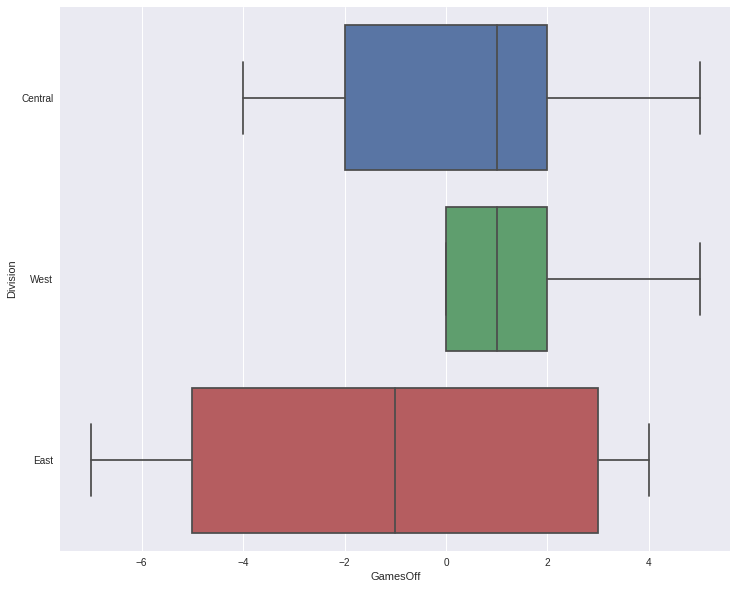

In [88]:
myResults = teams_to_predictAL[['Team','GamesWon','myGamesWon','GamesOff','Division']]
myResults.sort_values(['GamesOff'], inplace = True,ascending=False)
sns.boxplot(x="GamesOff", y="Division", data=myResults)#, order=myResults.groupby(['Division'])['GamesOff'].mean().sort_values(ascending=True).index.values)
print(myResults)